In [3]:
import warnings
warnings.filterwarnings("ignore")

## RAG search and answer



RAG stands for Retrieval Augmented Generation.


Which is another way of saying "given a query, search for relevant resources and answer based on those resources".


Let's breakdown each step:
* **Retrieval** - Get relevant resources given a query. For example, if the query is "what are the macronutrients?" the ideal results will contain information about protein, carbohydrates and fats (and possibly alcohol) rather than information about which tractors are the best for farming (though that is also cool information).
* **Augmentation** - LLMs are capable of generating text given a prompt. However, this generated text is designed to *look* right. And it often has some correct information, however, they are prone to hallucination (generating a result that *looks* like legit text but is factually wrong). In augmentation, we pass relevant information into the prompt and get an LLM to use that relevant information as the basis of its generation.
* **Generation** - This is where the LLM will generate a response that has been flavoured/augmented with the retrieved resources. In turn, this not only gives us a potentially more correct answer, it also gives us resources to investigate more (since we know which resources went into the prompt).

# similarity search

    Embeddings can work on any type of data. You can turn images , sound , text into embeddings

    comparing the embeddings is kwn as smiliarity search ,vector search or semantic search

    here we specfically want to query on our nutrition textbook passage based on semantics

    so if i search "macronutrient fucntion we specfically get relevenat pssages to that" may not contain exacyly the words


In [4]:
import pandas as pd

text_chunks_and_embedding_df = pd.read_csv("Text_chunks_and_embeddings.csv")

text_chunks_and_embedding_df.head()

,Unnamed: 0,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,Embedding
0,0,-39,HumanNutrition:2020\nEdition\nUNIVERSITYOFHAWA...,279,1,69.75,[ 7.18656480e-02 1.01327978e-01 -1.19499778e-...
1,1,-38,HumanNutrition:2020EditionbyUniversityofHawai‘...,183,1,45.75,[ 5.26484959e-02 5.23235723e-02 -2.51178294e-...
2,2,-37,Contents\nPreface\nUniversityofHawai‘iatMānoaF...,684,1,171.00,[ 4.08818461e-02 7.68153146e-02 -3.48349959e-...
3,3,-36,LifestylesandNutrition\nUniversityofHawai‘iatM...,835,1,208.75,[ 5.70069365e-02 5.55698760e-02 -1.27822775e-...
4,4,-35,TheCardiovascularSystem\nUniversityofHawai‘iat...,886,1,221.50,[ 2.94899847e-02 3.18359658e-02 -2.55909506e-...


In [5]:
import random

import torch

import numpy as np
import pandas as pd

device = "cuda" if torch.cuda.is_available() else 'cpu'

#importing the text and embedding df

text_chunks_and_embedding_df = pd.read_csv("Text_chunks_and_embeddings.csv")

#convert embeding columnback tonp,array it get chnaged to string when in csv

text_chunks_and_embedding_df['Embedding'] = text_chunks_and_embedding_df["Embedding"].apply(lambda x:np.fromstring(x.strip("[]"),sep=" "))

# convert text and embedding df into list of dicts

pages_and_chunks = text_chunks_and_embedding_df.to_dict(orient="records")

# convert Emneddings o torch tensor and send to device( numpy array are float64 , and torch tensors are float 32 by defailt)

embeddings = torch.tensor(np.array(text_chunks_and_embedding_df["Embedding"].to_list()),dtype=torch.float32).to(device)

embeddings.shape

torch.Size([1663, 768])

In [6]:
embeddings[0]

tensor([ 7.1866e-02,  1.0133e-01, -1.1950e-02, -2.5448e-02,  8.0988e-02,
         1.4599e-02, -3.3628e-02,  2.9365e-02,  2.0175e-02,  2.0108e-02,
         5.4997e-02,  3.0813e-02, -1.2326e-02,  6.0932e-02,  1.8747e-02,
        -1.6244e-02,  3.4303e-02,  3.1545e-02, -1.5452e-02,  1.1309e-02,
        -3.1186e-02,  1.2015e-02,  2.7226e-02, -7.0671e-03, -7.0597e-02,
         1.4678e-02,  3.2833e-02,  5.1079e-02, -2.5984e-02, -5.7846e-02,
         1.4610e-04,  5.0410e-02,  4.0628e-03, -7.7835e-02,  2.6053e-06,
        -4.1093e-02, -4.1227e-02,  4.0439e-02, -6.8943e-02,  5.0789e-02,
         2.4273e-02, -5.5337e-02, -7.2950e-03,  7.7740e-03,  3.9323e-02,
         1.8498e-02,  5.9556e-02,  2.8133e-02, -1.2278e-02, -1.8932e-02,
         1.4404e-02,  5.0606e-03,  5.4287e-03,  4.0868e-03,  3.0587e-02,
         1.5359e-02, -1.8559e-02,  4.9077e-02,  7.1774e-03, -3.9283e-02,
         2.2728e-02,  5.5619e-02,  3.2349e-02,  8.9124e-03,  8.7005e-03,
         6.1472e-02, -3.9548e-02, -9.1487e-02,  1.1

# creating another instance of our model to embedd the queries



In [7]:
from sentence_transformers import util , SentenceTransformer

embedding_model = SentenceTransformer(model_name_or_path="all-mpnet-base-v2",device=device)



# here the emnedding model is ready

i will try to implement a small semantic search pipeline

i will try something about macronutrient fucntions  and get back something relevant from the original embeddings

1) Define the query prompt
2) convert the  query string or prompt imto embedding
3) compute the similarity between the query embedding and the original embeddings cosine similarity or dot product
4) rank the results based on the similarity score descending 3

# We are using torch.tensor as our database here as the dataset size is small

In [8]:
#1 define the query
query = "Good food fror proteins"
print(f"Query:{query}")

#2 embed the query( we have to emned the query with same model which we used for the paassage)

query_embedding = embedding_model.encode(query,convert_to_tensor=True).to('cpu')

#3 get similarity scores wuth dot product(use cosne if outputs of model are not normalized) i mean scattered

from time import perf_counter as timer

start_time = timer()
dot_scores = util.dot_score(a= query_embedding,b=embeddings)
end_time = timer()

print(f"[INFO] Time taken to get scores on {len(embeddings)}:{end_time-start_time:.5f} seconds.")

# printing the top 5 results
top_results_dot_product = torch.topk(dot_scores,k=5)

top_results_dot_product

Query:Good food fror proteins
[INFO] Time taken to get scores on 1663:0.00076 seconds.


torch.return_types.topk(
values=tensor([[0.6536, 0.6086, 0.5920, 0.5803, 0.5768]]),
indices=tensor([[ 604,  611,  613, 1062,  600]]))

In [9]:
print(type(dot_scores))

<class 'torch.Tensor'>


# lets check the indices and see if we are getting relvant information

In [10]:
pages_and_chunks[1146]

{'Unnamed: 0': 1146,
 'page_number': 819,
 'sentence_chunk': 'breastfedinfants,6monthsofageisagoodtimetointroduce\nsourcesofhighlybioavailableironandzincsuchasbabymeats.\nIron-fortifiedcerealsandbeanscanboosttheironintakeaswell.\nFluids\nInfantshaveahighneedforfluids,1.5millilitersperkilocalorie\nconsumedcomparedto1.0millilitersperkilocalorieconsumedfor\nadults.Thisisbecausechildrenhavelargerbodysurfaceareaper\nunitofbodyweightandahighermetabolicrate.Therefore,theyare\natgreaterriskofdehydration.However,parentsorothercaregivers\ncanmeetaninfant’sfluidneedswithbreastmilkorformula.As\nsolidsareintroduced,parentsmustmakesurethatyoungchildren\ncontinuetodrinkfluidsthroughouttheday.\nInfancy|819',
 'chunk_char_count': 625,
 'chunk_word_count': 1,
 'chunk_token_count': 156.25,
 'Embedding': array([ 2.42738370e-02, -5.57303755e-03,  9.47513245e-03, -1.68213490e-02,
         2.17480138e-02,  2.82879099e-02, -4.99850605e-03,  2.58132406e-02,
         2.51434022e-03, -1.79842766e-02,  2.67563611

# lets get the helper function to get better results with the search similarity



In [11]:
import textwrap





def print_wrapped(text, wrap_length=80):
    wrapped_text = textwrap.fill(text, wrap_length)
    print(wrapped_text)

# Assuming top_results_dot_product is a tuple of (scores, indices) obtained from torch.topk


# Debugging: Check the shapes and content
print(f"Shape of top_results_dot_product[0]: {top_results_dot_product[0].shape}")
print(f"Shape of top_results_dot_product[1]: {top_results_dot_product[1].shape}")
print(f"Content of top_results_dot_product[1]: {top_results_dot_product[1]}")

print(f"Query: '{query}'\n")
print("Results:")

# Loop through zipped together scores and indices from torch.topk
for score, idx in zip(top_results_dot_product[0], top_results_dot_product[1]):
    # Ensure score is a scalar tensor
    if score.numel() == 1:  # Check if the tensor has only one element
        score = score.item()  # Convert tensor to float
    else:
        # If there are multiple elements, log the issue and use the first element as fallback
        print(f"Warning: score tensor has {score.numel()} elements. Using the first element.")
        score = score.flatten()[0].item()  # Flatten and get the first element
    
    # Convert each idx element to integer and handle each one
    for i in idx:
        idx_int = i.item()  # Convert idx tensor element to an integer
        print(f"Score: {score:.4f}")
        # Print relevant sentence chunk (since the scores are in descending order, the most relevant chunk will be first)
        print("Text:")
        print_wrapped(pages_and_chunks[idx_int]["sentence_chunk"])
        # Print the page number too so we can reference the textbook further (and check the results)
        print(f"Page number: {pages_and_chunks[idx_int]['page_number']}")
        print("\n")


Shape of top_results_dot_product[0]: torch.Size([1, 5])
Shape of top_results_dot_product[1]: torch.Size([1, 5])
Content of top_results_dot_product[1]: tensor([[ 604,  611,  613, 1062,  600]])
Query: 'Good food fror proteins'

Results:
Score: 0.6536
Text:
DietarySourcesofProtein Theproteinfoodgroupconsistsoffoodsmadefrommeat,seafood,
poultry,eggs,soy,drybeans,peas,andseeds.Accordingtothe
HarvardSchoolofPublicHealth,“animalproteinandvegetable
proteinprobablyhavethesameeffectsonhealth.It’stheprotein
packagethat’slikelytomakeadifference.”1
1. Protein:TheBottomLine.HarvardSchoolofPublic
Proteins,Diet,andPersonalChoices|411
Page number: 411


Score: 0.6536
Text:
Protein-rich Foodsby Smastronard o/CC BY-SA4.0
Examplesofcompleteproteinsourcesincludesoy,dairyproducts,
meat,andseafood.Examplesofincompleteproteinsourcesinclude legumesandcorn.
Mostplant-basedfoodsaredeficientinatleastoneessential
aminoacidandthereforeareincompleteproteinsources.For
example,grainsareusuallydeficientintheaminoacidly

# The ranking of these results can be arranged with the help of ranking models
 specifially to take search results and rank them in order from most likely to least likely

 Will deal with these later
  https://www.mixedbread.ai/blog/mxbai-rerank-v1
  

# now lets print the page directly just experiment

# will need to automate the page display

<function matplotlib.pyplot.show(close=None, block=None)>

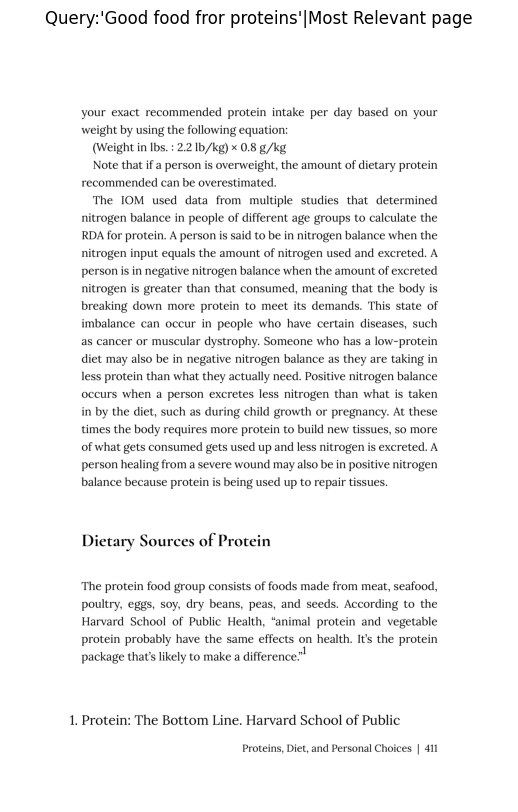

In [12]:
import fitz

pdf_path = "Nutrition_text_book.pdf"
doc =fitz.open(pdf_path)

page = doc.load_page(411+41)

# getting the image of the page
img = page.get_pixmap(dpi= 400)

#optional saving the image
img_array = np.frombuffer(img.samples_mv,dtype=np.uint8).reshape((img.h,img.w,img.n))

doc.close

#using matplotlib

import matplotlib.pyplot as plt
plt.figure(figsize=(13,10))
plt.imshow(img_array)
plt.title(f"Query:'{query}'|Most Relevant page")
plt.axis('off' )
plt.show


# cosine similarity fornulae

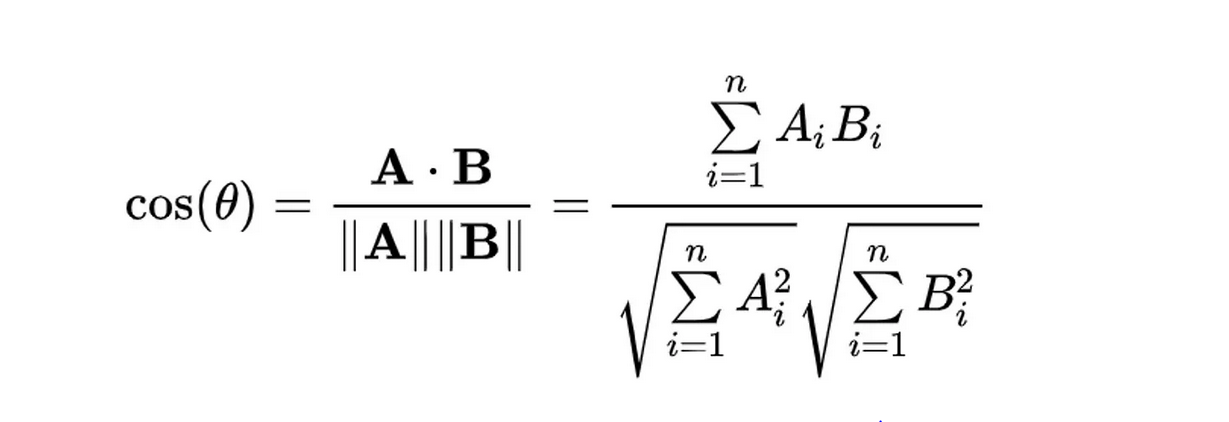

In [15]:
# trying out the semnactic serach pipeline

def retrieve_relevant_sources(query:str,
                              embeddings:torch.tensor,
                              model:SentenceTransformer=embedding_model,
                              n_resources_to_return:int =5,
                              print_time:bool = True):
    
    """
    embeds the query with the model and returns top k scores and indices from embeddings
    """
    query_embedding = model.encode(query,convert_to_tensor=True)

    #getting the dot prodict for similarity scores
    start_time = timer()
    dot_scores = util.dot_score(query_embedding,embeddings)[0]
    end_time = timer()

    if print_time:
        print(f"Time taken to compute dot scores on {len(embeddings)} is {end_time-start_time:.5f} seconds")

    scores ,indices =  torch.topk(input=dot_scores,k= n_resources_to_return)


    return scores , indices


def print_top_results_and_scores(query:str,
                                 embeddings:torch.tensor,
                                 pages_and_chunks:list[dict]=pages_and_chunks,
                                 n_resources_to_return :int =5):

    """
    Take the query and return the most relevant resource and print them out in descending order
    The formatting needs to be done in  a specific way ( )
    """    
    scores , indices = retrieve_relevant_sources(query=query,embeddings=embeddings,n_resources_to_return=n_resources_to_return)
    print(f"Query:{query}\n")
    print("Results")

    for score ,index in zip(scores,indices):
        print(f"score:{score:.4f}")

        # printing the relevant sentence chunk
        print_wrapped(pages_and_chunks[index]["sentence_chunk"])

        print(f"Page Number:{pages_and_chunks[index]['page_number']}")
        print(f"\n")
              

In [16]:
query = " symptoms of pelleagra" 

scores , indices = retrieve_relevant_sources(query=query,embeddings=embeddings)

scores , indices

Time taken to compute dot scores on 1663 is 0.00055 seconds


(tensor([0.3612, 0.3323, 0.3310, 0.3125, 0.2981]),
 tensor([  51, 1401, 1400,  271, 1406]))

In [17]:
print_top_results_and_scores(query=query,embeddings=embeddings)

Time taken to compute dot scores on 1663 is 0.00071 seconds
Query: symptoms of pelleagra

Results
score:0.3612
Vitamins MajorFunctions Water-soluble Thiamin(B1)
Coenzyme,energymetabolismassistance Riboflavin(B2)
Coenzyme,energymetabolismassistance Niacin(B3)
Coenzyme,energymetabolismassistance Pantothenicacid (B5)
Coenzyme,energymetabolismassistance Pyridoxine(B6)
Coenzyme,aminoacidsynthesisassistance Biotin(B7)
Coenzyme,aminoacidandfattyacidmetabolism Folate(B9) Coenzyme,essentialforgrowth
Cobalamin(B12) Coenzyme,redbloodcellsynthesis C(ascorbicacid)
Collagensynthesis,antioxidant Fat-soluble A
Vision,reproduction,immunesystemfunction D
Boneandteethhealthmaintenance,immunesystem function E
Antioxidant,cellmembraneprotection K Boneandteethhealthmaintenance,bloodclotting
Vitamindeficienciescancauseseverehealthproblemsandeven
death.Forexample,adeficiencyinniacincausesadiseasecalled
pellagra,whichwascommonintheearlytwentiethcenturyinsome
partsofAmerica.Thecommonsignsandsymptomsofpellagra
a